In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import torch.nn.init as init  

In [2]:
# 加载数据集  
train_df = pd.read_csv('./数据/KDDTrain+afterP.csv')  # 使用ADASYN进行数据不平衡处理（数据增强）的效果是最好的
test_df = pd.read_csv('./数据/KDDTest+afterP.csv')

# 划分训练集和测试集的标签和特征
y_train = train_df['attack_type']
X_train = train_df.drop(columns = ['attack_type'])
y_test = test_df['attack_type']
X_test = test_df.drop(columns = ['attack_type'])

# 需要把类别特征进行数值化：['dos','normal','probe','r2l','u2r']分别映射为0 1 2 3 4
from sklearn.preprocessing import LabelEncoder  
# 初始化LabelEncoder  
le = LabelEncoder()  
  
# 对y_train中的类别特征进行数值化  
y_train_encoded = le.fit_transform(y_train)  

# 对y_test中的类别特征进行数值化  
y_test_encoded = le.fit_transform(y_test)  

# 将数据转换为PyTorch张量格式,才能进行后续的运算 （需要Numpy格式进行转换）
X_train = torch.tensor(X_train.values, dtype=torch.float32)  
y_train_encoded = torch.tensor(y_train_encoded, dtype=torch.long)  
X_test = torch.tensor(X_test.values, dtype=torch.float32)  
y_test_encoded = torch.tensor(y_test_encoded, dtype=torch.long) 

# 使用one_hot函数将类别数字转换为独热编码, 条件变分自编码器需要输入标签最好是进行了独热编码  
y_train_encoded = F.one_hot(y_train_encoded, num_classes=5) 

In [3]:
# print(y_train_encoded)

In [4]:
# 创建数据加载器  
train_dataset = TensorDataset(X_train, y_train_encoded)  
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)  

test_dataset = TensorDataset(X_test, y_test_encoded)  
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False) 

In [5]:
# 条件批量归一化：把数据的类别信息融合到归一化过程中，用类别信息控制缩放（weight）和bias
# 公式结合了标准批归一化和类别特定的偏移和缩放，使得归一化过程能够依赖于输入的类别标签
class ConditionalBatchNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ConditionalBatchNorm, self).__init__()
        # num_features: 批归一化层需要处理的特征数量。
        # num_classes: 类别标签的数量。
        self.num_features = num_features
        self.num_classes = num_classes

        # gamma: 可学习的缩放因子，大小为num_features。
        # beta: 可学习的偏移量，初始化为零，大小为num_features。
        # weight: 类别特定的缩放因子，大小为num_classes x num_features。
        # bias: 类别特定的偏移量，大小为num_classes x num_features。
        # 这些都可以通过参数进行学习
        self.gamma = nn.Parameter(torch.Tensor(num_features))
        #######使用标准正态分布初始化缩放因子，防止输出过大或者过小
        nn.init.normal_(self.gamma, mean=0, std=1)  
        self.beta = nn.Parameter(torch.zeros(num_features))  
        self.weight = nn.Parameter(torch.Tensor(num_classes, num_features))  # 这些全都是可以训练的参数 一个表格存储各个类的w和b
        self.bias = nn.Parameter(torch.zeros(num_classes, num_features)) 
        ####### 使用 Xavier Uniform 初始化，防止初始化值异常导致输出异常，出现损失函数异常
        nn.init.xavier_uniform_(self.weight)  
  
    def forward(self, x, y):  
        batch_size = x.size(0)  
        # 通过y索引相应类别的w和b；重塑w和b与x相同形状
        # 使用矩阵乘法实现通过独热编码y选择
        y = y.float()
        weight = torch.matmul(y, self.weight) 
        bias = torch.matmul(y, self.bias) 
        # 对x的最后一个特征维度做归一化（减去均值除以方差）
        x_mean = x.mean(-1, keepdim=True)           #.mean(-2, keepdim=True)  
        x_var = x.var(-1, keepdim=True)             # .var(-2, keepdim=True)  
        return self.gamma * (x - x_mean) / torch.sqrt(x_var + 1e-5) + self.beta + weight * x_mean + bias 

In [6]:
# 条件自注意力机制：更关注条件相关的特征（乘更大的权重），从而生成更符合条件（类别）的特征
# 采用自注意力机制！######### 当前元素与其他元素的相似度计算注意力权重
# 捕捉不同特征之间的远距离依赖关系
class ConditionalSelfAttention(nn.Module):
    def __init__(self, in_features, label_dim, attention_dim):
        super(ConditionalSelfAttention, self).__init__()
        # QKV就是三个输入X的线性变换，通过三个可以训练的权重增强模型的拟合能力；
        self.query = nn.Linear(in_features, attention_dim, bias=False)
        self.key = nn.Linear(in_features, attention_dim, bias=False)
        self.value = nn.Linear(in_features, attention_dim, bias=False)
        self.gamma = nn.Parameter(torch.zeros(1)) # 可学习的参数 控制注意力机制的缩放
        # 将输入编码为稠密向量，并且变成注意力维度，与QKV逐元素合并，引入条件因素;embedding接受离散的索引作为输入（和Linear类似）
        self.label_embedding = nn.Linear(label_dim, attention_dim)
        self.fc = nn.Linear(attention_dim,in_features)
        # 使用xaiver初始化
        init.xavier_uniform_(self.query.weight)
        init.xavier_uniform_(self.key.weight)
        init.xavier_uniform_(self.value.weight)
        init.xavier_uniform_(self.label_embedding.weight)
        init.xavier_uniform_(self.fc.weight)

    def forward(self, x, labels):
        # 条件嵌入
        labels = labels.to(torch.float32)
        label_emb = self.label_embedding(labels)
        # print(label_emb.shape) # 128 30
        # 计算 QKV （x的线性变换）
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        # print(q.shape) # 128 30
        # 加入条件信息QKV
        q = q + label_emb  
        k = k + label_emb  
        v = v + label_emb 
        q = q.unsqueeze(2)# 列向量
        k = k.unsqueeze(2)# 列向量 下面转置变成行向量
        # print(q.shape) # 128 30 1
        # 计算注意力权重（核心公式）
        # QK转置 做batch矩阵乘法得到注意力分数（特征之间相关程度、关联性） 列向量乘行向量得到矩阵
        attn = torch.bmm(q, k.transpose(1, 2))
        # print(attn.shape) # 128 30 30
        # 除以缩放因子:缩放因子是根号下k的维度 防止分数过大 梯度饱和 type as保证相同的数据类型和设备类型
        attn = attn / torch.sqrt(torch.tensor(k.size(-1)).type_as(q))  
        # 归一化 将每一列上的注意力分数的和设为一
        attn = F.softmax(attn, dim=-1)
        v = v.unsqueeze(2) # 128 30 1
        # 应用注意力权重到 V（加权求和） 30 30 x 30 1 = 30 1
        attn_output = torch.bmm(attn, v)
        # print(attn_output.shape)
        attn_output = attn_output.squeeze(-1)
        attn_output = self.fc(attn_output)
        # 残差连接
        attn_output = self.gamma * attn_output + x
        return attn_output

In [7]:
class CNN(nn.Module):  
    def __init__(self, input_dim, hidden_dim):  
        super(CNN, self).__init__()  
        self.fc_r = nn.Linear(input_dim,hidden_dim)
        init.xavier_uniform_(self.fc_r.weight)  # 使用Xavier均匀分布初始化权重 
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.ln1 = nn.LayerNorm(normalized_shape=[60])
        self.ln2 = nn.LayerNorm(normalized_shape=[30])  
        self.leakyrelu = nn.LeakyReLU()  
        self.dropout = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool1d(kernel_size=2)  
        self.flatten = nn.Flatten()  
        self.fc = nn.Linear(128 * 15, 1)
        self.sigmoid = nn.Sigmoid()  
        init.xavier_uniform_(self.conv1.weight)
        init.xavier_uniform_(self.conv2.weight)
        init.xavier_uniform_(self.conv3.weight)
        init.xavier_uniform_(self.conv4.weight)
        init.xavier_uniform_(self.fc.weight)
  
    def forward(self, x): 
        x = self.fc_r(x)
        x = x.unsqueeze(1)  # 增加通道维度  b 1 60
        x = self.conv1(x)  # b 16 60
        x = self.ln1(x)
        x = self.leakyrelu(x) 
        x = self.dropout(x)
        x = self.conv2(x)  # b 32 60
        x = self.ln1(x)
        x = self.leakyrelu(x) 
        x = self.dropout(x)
        
        x = self.maxpool(x) 
        
        x = self.conv3(x)  # b 64 30
        x = self.ln2(x)
        x = self.leakyrelu(x) 
        x = self.dropout(x)
        x = self.conv4(x)  # b 128 30
        x = self.ln2(x)
        x = self.leakyrelu(x) 
        x = self.dropout(x)
        
        x = self.maxpool(x)
        
        x = self.flatten(x)  # b 128x15
        x = self.fc(x)  # b 1
        x = self.sigmoid(x) # 输出一个概率值，是真数据还是假数据 表示输入数据是真实的概率
        return x  

In [8]:
# 定义GAN模型

# 条件GAN：定义，需要输入标签，条件信息就是标签，与噪声结合后生成数据
# 生成器：输入噪声 输出生成的数据；
class Generator(nn.Module):  
    def __init__(self, input_dim, label_dim, output_dim):  
        super(Generator, self).__init__()  
        
        self.fc1 = nn.Linear(input_dim + label_dim, 100) 
        
        self.fc21 = nn.Linear(100,100)
        self.fc22 = nn.Linear(100,100)
        self.fc23 = nn.Linear(100,100)
        self.fc24 = nn.Linear(100,100)
        
        self.bn1 = nn.BatchNorm1d(100)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(100)
        self.bn4 = nn.BatchNorm1d(100)
        self.bn5 = nn.BatchNorm1d(100)
        
        self.bn_output = nn.BatchNorm1d(output_dim)
        self.fc3 = nn.Linear(100, output_dim)
        self.csa1 = ConditionalSelfAttention(100,label_dim,30)
        self.csa2 = ConditionalSelfAttention(100,label_dim,30)
        # 使用的是RELU的变体 用Kaiming初始化
        init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')  
        init.kaiming_normal_(self.fc21.weight, mode='fan_out', nonlinearity='relu') 
        init.kaiming_normal_(self.fc22.weight, mode='fan_out', nonlinearity='relu') 
        init.kaiming_normal_(self.fc23.weight, mode='fan_out', nonlinearity='relu') 
        init.kaiming_normal_(self.fc24.weight, mode='fan_out', nonlinearity='relu') 
        init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu')   
        
        
   # 输入随机噪声
    def forward(self, z, labels):  
        combined = torch.cat((z, labels), 1)  # 将标签和噪声拼接
        x = self.fc1(combined)  
        x = self.bn1(x)  
        x = F.leaky_relu(x) 
        x = self.fc21(x)
        x = self.csa1(x, labels) # 条件自注意力机制
        x = self.bn2(x)        
        x = F.leaky_relu(x)
        x = self.fc22(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.fc23(x)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x = self.fc24(x)
        # x = self.csa2(x, labels) # 条件自注意力机制
        x = self.bn5(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = self.bn_output(x)
        return x  
    
class Discriminator(nn.Module):  
    def __init__(self, input_dim, label_dim, hidden_dim):  
        super(Discriminator, self).__init__()  
        self.cnn = CNN(input_dim + label_dim, hidden_dim)
    
    def forward(self, x, labels):
        x = self.cnn(x)
        return x
    
# class Discriminator(nn.Module):  
#     def __init__(self, input_dim, label_dim):  
#         super(Discriminator, self).__init__()  
#         self.fc1 = nn.Linear(input_dim + label_dim, 100) 
#         self.fc2 = nn.Linear(100,50)
#         self.bn1 = nn.BatchNorm1d(100)   
#         self.fc3 = nn.Linear(50, 50)  
#         self.fc4 = nn.Linear(50, 1)                   
#         self.bn2 = nn.BatchNorm1d(50)
#         self.dropout = nn.Dropout(0.3)
#         self.sigmoid = nn.Sigmoid()  
#         self.csa1 = ConditionalSelfAttention(100,label_dim,30)
#         self.csa2 = ConditionalSelfAttention(50,label_dim,30)
#         init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')  
#         init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu') 
#         init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu') 
#         init.kaiming_normal_(self.fc4.weight, mode='fan_out', nonlinearity='relu') 
  
#     def forward(self, x, labels):
#         # x = self.dropout(x) # 防止判别器性能过强
#         x = self.fc1(x)  
#         x = self.bn1(x)  
#         x = F.leaky_relu(x)
#         x = self.csa1(x,labels) # 判别器中运用条件自注意力
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = F.leaky_relu(x)
#         x = self.fc3(x)
#         x = self.bn2(x)
#         x = F.leaky_relu(x)
#         x = self.csa2(x,labels) # 判别器中运用条件自注意力
#         x = self.fc4(x)
#         x = self.sigmoid(x) # 输出一个概率值，是真数据还是假数据 表示输入数据是真实的概率
#         return x  

# 初始化生成器和判别器
input_dim = 123  
output_dim = 123
label_dim = 5
hidden_dim = 60
generator = Generator(input_dim, label_dim, output_dim)
discriminator = Discriminator(output_dim , label_dim, hidden_dim) 

In [13]:
from thop import profile
from thop import clever_format
z = torch.randn(1,123)
labels = torch.randn(1,5)
flops_G, params_G = profile(generator, inputs=(z,labels))
flops_G, params_G = clever_format([flops_G, params_G], '%.3f')

print('Network Parameters：',params_G)
print('FLOPs per sample：',flops_G)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
Network Parameters： 79.249K
FLOPs per sample： 79.742K


In [14]:
x = torch.randn(1,128)
labels = torch.randn(1,5)
flops_D, params_D = profile(discriminator, inputs=(x,labels))
flops_D, params_D = clever_format([flops_D, params_D], '%.15f')

print('Network Parameters：',params_D)
print('FLOPs per sample：',flops_D)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
Network Parameters： 42.384999999999998K
FLOPs per sample： 1.060800000000000M


In [9]:
# 定义损失函数和优化器
criterion = nn.BCELoss()  # 采用二元交叉熵损失函数
optimizer_G = optim.Adam(generator.parameters(), lr=0.0009)  # 异步更新
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000007)  

In [10]:
# 按指数调整学习率 每个epoch之后学习率乘0.7
scheduler_D = torch.optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=0.9999)
scheduler_G = torch.optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=0.9)

In [11]:

# 检查是否有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 将模型移动到GPU上
generator = generator.to(device)
discriminator = discriminator.to(device)
# 将数据移动到GPU上
X_train = X_train.to(device)
y_train_encoded = y_train_encoded.to(device)
X_test = X_test.to(device)
y_test_encoded = y_test_encoded.to(device)

In [12]:
############加载模型
# 选择一个加载模型参数的文件路径
load_path ='cgan_model_para_bl_30_0007.pth'
# 使用 torch.load() 函数加载模型参数
loaded_parameters = torch.load(load_path)
# 加载模型参数到模型中
generator.load_state_dict(loaded_parameters)
# 打印加载成功的消息  
print(f"CGAN model parameters have been loaded from {load_path}")

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "fc21.weight", "fc21.bias", "fc22.weight", "fc22.bias", "fc23.weight", "fc23.bias", "fc24.weight", "fc24.bias", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "bn5.weight", "bn5.bias", "bn5.running_mean", "bn5.running_var", "csa1.gamma", "csa1.query.weight", "csa1.key.weight", "csa1.value.weight", "csa1.label_embedding.weight", "csa1.label_embedding.bias", "csa1.fc.weight", "csa1.fc.bias", "csa2.gamma", "csa2.query.weight", "csa2.key.weight", "csa2.value.weight", "csa2.label_embedding.weight", "csa2.label_embedding.bias", "csa2.fc.weight", "csa2.fc.bias". 
	Unexpected key(s) in state_dict: "fc2.weight", "fc2.bias", "bn.weight", "bn.bias", "bn.running_mean", "bn.running_var", "bn.num_batches_tracked". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([200, 128]) from checkpoint, the shape in current model is torch.Size([100, 128]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([200]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([123, 200]) from checkpoint, the shape in current model is torch.Size([123, 100]).

In [79]:
d_losses_add = []
g_losses_add = []

In [80]:
# 训练模型
num_epochs = 30
k = 3 # 先训练k轮判别器 再训练一轮生成器（交替训练）
d_losses = []
g_losses = []

for epoch in range(num_epochs):  
    discriminator_loss_sum = 0
    generator_loss_sum = 0
    fake_sum = 0
    real_sum = 0
    for j in range(k):
        for i, (real_samples, real_labels) in enumerate(train_loader):  
            #######训练判别器########
            real_labels = real_labels.type(torch.FloatTensor).to(device) 
            optimizer_D.zero_grad()  
            real_samples = real_samples.type(torch.FloatTensor).to(device)  
            # 将真实的数据和条件（类别标签）输入到判别器中 判别器输出是真实样本的概率
            real_output = discriminator(torch.cat((real_samples, real_labels), 1),real_labels) 
            real_sum += real_output[1].item()
            # 判别器对所有真实样本的输出都接近1 torch.ones_like(real_output)表示一个与realoutput形状类型相同的1的张亮
            real_loss = criterion(real_output, torch.ones_like(real_output))  

            # 产生随机噪声：从标准正态分布中随机抽取值； 形成(real_samples.size(0)样本数量, input_dim噪声维度)形状
            z = torch.randn(real_samples.size(0), input_dim).to(device)
            # 噪声和条件标签生成假样本
            fake_samples = generator(z, real_labels)
            fake_output = discriminator(torch.cat((fake_samples, real_labels), 1),real_labels)
            fake_sum += fake_output[1].item()
            fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
            # 判别器总损失（两部分组成）
            # # 给fakeloss加上权重
            # p = 2
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()
            discriminator_loss_sum += d_loss.item()
            # if(i+1)%200 == 0:
            #     print(d_loss.item())
    scheduler_D.step()
        
    for i, (real_samples, real_labels) in enumerate(train_loader):  
        ########训练生成器########
        real_samples = real_samples.to(device)
        real_labels = real_labels.to(device)
        optimizer_G.zero_grad() 
        # 生成假样本
        z = torch.randn(real_samples.size(0), input_dim).to(device)
        fake_samples = generator(z, real_labels)
        # 判别器应该认为这些假样本是真实的
        fake_output = discriminator(torch.cat((fake_samples, real_labels), 1),real_labels)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))
        # 反向传播和优化生成器
        g_loss.backward()
        optimizer_G.step()
        generator_loss_sum += g_loss.item()
    generator_avg_loss = generator_loss_sum / (len(train_loader))
    # 计算判别器k轮的平均损失
    discriminator_loss_avg = discriminator_loss_sum / (len(train_loader) * k)
    g_losses.append(generator_avg_loss)
    d_losses.append(discriminator_loss_avg)
    fake_avg = fake_sum / (len(train_loader) * k)
    real_avg = real_sum  / (len(train_loader) * k)
    print(f"Epoch [{epoch+1}/{num_epochs}], D_Loss: {discriminator_loss_avg},G_Loss: {generator_avg_loss},fake_p:{fake_avg},real_p:{real_avg}")
    scheduler_G.step()
    ##判别器的损失增大可能是因为生成器逐渐逼真，判别能力逐渐下降

Epoch [1/30], D_Loss: 0.5331061317583833,G_Loss: 0.20381014069050626,fake_p:0.19800598555316562,real_p:0.8268166732055635
Epoch [2/30], D_Loss: 0.2386542268462996,G_Loss: 0.07608891817372349,fake_p:0.07972360541725959,real_p:0.9339716977460306
Epoch [3/30], D_Loss: 0.32901105760027816,G_Loss: 0.08739883401856621,fake_p:0.10276467856693838,real_p:0.9200447303707855
Epoch [4/30], D_Loss: 0.3178268452561043,G_Loss: 0.13524963634873405,fake_p:0.09604304742212666,real_p:0.9260400684143837
Epoch [5/30], D_Loss: 0.28078254649349427,G_Loss: 0.09660512652900542,fake_p:0.08473074800314952,real_p:0.9271057969406752
Epoch [6/30], D_Loss: 0.3079653098530021,G_Loss: 0.10144987176574274,fake_p:0.0924614381359979,real_p:0.930163059141739
Epoch [7/30], D_Loss: 0.3301951026919025,G_Loss: 0.12577203361761902,fake_p:0.09728975442985464,real_p:0.9179695555614465
Epoch [8/30], D_Loss: 0.3902306240789479,G_Loss: 0.13526330538245324,fake_p:0.11363170180371193,real_p:0.9003751819004665
Epoch [9/30], D_Loss: 0.

In [31]:
# d_losses_add += d_losses
# g_losses_add += g_losses
d_losses_add = d_losses_add[:60]
g_losses_add = g_losses_add[:60]

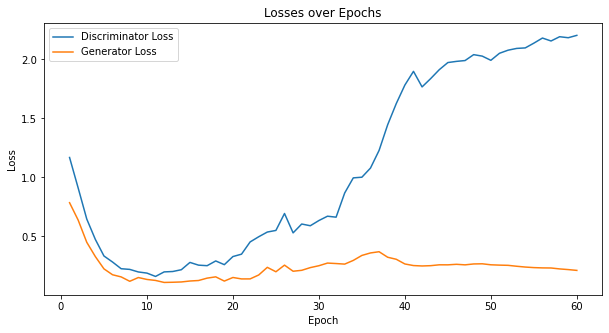

In [33]:
# 绘制D和G轮平均损失的变化图
import matplotlib.pyplot as plt  

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(d_losses_add) + 1), d_losses_add, label='Discriminator Loss')
plt.plot(range(1, len(g_losses_add) + 1), g_losses_add, label='Generator Loss')
plt.title('Losses over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [54]:
# for i, (real_samples, real_labels) in enumerate(train_loader): 
#         real_samples = real_samples.to(device)
#         real_labels = real_labels.to(device)
#         # 生成假样本
#         z = torch.randn(real_samples.size(0), input_dim).to(device)
#         fake_samples = generator(z, real_labels)
#         fake_output = discriminator(torch.cat((fake_samples, real_labels), 1))
#         real_labels = real_labels.type(torch.FloatTensor).to(device) 
#         real_samples = real_samples.type(torch.FloatTensor).to(device)  
#         real_output = discriminator(torch.cat((real_samples, real_labels), 1))
#         print(f"real_output: {real_output[1]},fake_output: {fake_output[1]}")

In [71]:
# 获取模型参数  
cgan_model_parameters = generator.state_dict()  
# 选择一个保存模型参数的文件路径  
save_path = 'cgan_model_para_bl_60ADA.pth'  
# 使用 torch.save() 函数保存模型参数  
torch.save(cgan_model_parameters, save_path)  
# 打印保存成功的消息  
print(f"cgan model parameters have been saved to {save_path}")

 
discrim_model_parameters = generator.state_dict()  
# 选择一个保存模型参数的文件路径  
save_path = 'discrim_model_para_bl_60ADA.pth'  
# 使用 torch.save() 函数保存模型参数  
torch.save(discrim_model_parameters, save_path)  
# 打印保存成功的消息  
print(f"discrim model parameters have been saved to {save_path}")

cgan model parameters have been saved to cgan_model_para_bl_60ADA.pth
discrim model parameters have been saved to discrim_model_para_bl_60ADA.pth


In [81]:
from torch.distributions import Normal

# 通过生成器可以指定类别生成新数据：与训练所用数据相似但不相同  
def generate_new_data(generator,target_category, noise_dim, num_samples = 1):  
    generator.eval()
    # 准备目标类别的独热编码y  
    # target_category = 2  #（索引从0开始） 
    num_classes = 5
    y_onehot = torch.zeros(num_samples, num_classes)  # num_classes是类别的总数  
    y_onehot[:, target_category] = 1  # 设置每一个样本目标类别的位置为1  
    y_onehot = y_onehot.to(device)
    # 从标准正态分布中随机采样噪声  
    noise = torch.randn(num_samples, noise_dim).to(device)  
    # 使用生成器生成数据  
    with torch.no_grad():  
        # 解码隐变量和标签以生成数据  
        generated_data = generator(noise, y_onehot)  
  
    return generated_data

# 设置要生成的数据数量
num_samples = 10
target_category = 0
# 生成新数据
new_data = generate_new_data(generator, target_category, 123, num_samples)

# 打印生成的数据的形状
print(new_data.shape)

torch.Size([10, 123])


In [82]:
# 分别生成 DOS 0类型样本 21416 个，Probe 2类型样本55687 个
# R2L 3类型样本 66348，U2R 4类型样本 67291 个
# 生成的样本与原样本混合，形成 VAE 过采样后的训练集，使得每种类别样本的数量都为 67343个。
# 设置要生成的数据数量  
num_samples = 21416  
target_category = 0
# 生成新数据  
new_data_dos = generate_new_data(generator, target_category, 123, num_samples)  

#生成标签的一维Tensor
labels = torch.full((num_samples,), target_category, dtype=torch.long)    
labels = labels.view(num_samples, 1)  
labels = labels.to(device)
# 可以沿着最后一个维度拼接数据和标签  
new_data_dos = torch.cat((new_data_dos, labels), dim=-1)  
  
# 输出结果以验证  
print(new_data_dos)  


tensor([[ 1.7985,  7.4932, 15.5198,  ..., -1.0452,  3.4480,  0.0000],
        [ 1.7997,  7.5103, 15.5229,  ..., -1.0510,  3.4467,  0.0000],
        [ 1.8137,  7.4756, 15.5375,  ..., -1.0360,  3.4478,  0.0000],
        ...,
        [ 4.2400,  3.2937, 39.5195,  ...,  3.8513, -0.2268,  0.0000],
        [ 1.8043,  7.5077, 15.5371,  ..., -1.0493,  3.4468,  0.0000],
        [ 1.7801,  7.5465, 15.5133,  ..., -1.0661,  3.4456,  0.0000]],
       device='cuda:0')


In [83]:
# 设置要生成的数据数量  
num_samples = 55687  
target_category = 2
# 生成新数据  
new_data_probe = generate_new_data(generator, target_category, 123, num_samples)  

#生成标签的一维Tensor
labels = torch.full((num_samples,), target_category, dtype=torch.long)  
# 为了拼接将标签Tensor扩展到与数据Tensor相同的维度  
labels = labels.view(num_samples, 1)  
labels = labels.to(device)
# 沿着最后一个维度拼接数据和标签  
new_data_probe = torch.cat((new_data_probe, labels), dim=-1)  
  
# 输出结果以验证  
print(new_data_probe)  

tensor([[12.0640, 20.4706, -1.2039,  ...,  2.6116, -2.6637,  2.0000],
        [12.1584, 20.5409, -1.2961,  ...,  2.6316, -2.6971,  2.0000],
        [12.2531, 20.6231, -1.3299,  ...,  2.6365, -2.7353,  2.0000],
        ...,
        [ 0.6887, 18.7603, 13.2584,  ..., -3.5146,  1.3614,  2.0000],
        [ 0.5209, 18.7096, 13.3173,  ..., -3.5893,  1.4620,  2.0000],
        [12.1701, 20.5416, -1.2848,  ...,  2.6341, -2.7083,  2.0000]],
       device='cuda:0')


In [84]:
# 设置要生成的数据数量  
num_samples = 66348  
target_category = 3
# 生成新数据  
new_data_r2l = generate_new_data(generator, target_category, 123, num_samples)  

#生成标签的一维Tensor
labels = torch.full((num_samples,), target_category, dtype=torch.long)  
# 为了拼接将标签Tensor扩展到与数据Tensor相同的维度  
labels = labels.view(num_samples, 1)  
labels = labels.to(device)
# 沿着最后一个维度拼接数据和标签  
new_data_r2l = torch.cat((new_data_r2l, labels), dim=-1)  
  
# 输出结果以验证  
print(new_data_r2l)  

tensor([[ 1.2691, 17.6626, 13.9976,  ..., -3.1791,  1.6086,  3.0000],
        [11.5919, 19.6011, -0.8965,  ...,  2.5569, -2.6976,  3.0000],
        [11.5677, 19.5801, -0.8871,  ...,  2.5482, -2.6885,  3.0000],
        ...,
        [11.4000, 19.4938, -0.7454,  ...,  2.4932, -2.5971,  3.0000],
        [ 0.5963, 17.9817, 13.4952,  ..., -3.2579,  1.3528,  3.0000],
        [11.5493, 19.6024, -0.8668,  ...,  2.5287, -2.6702,  3.0000]],
       device='cuda:0')


In [85]:
# 设置要生成的数据数量  
num_samples = 67291  
target_category = 4
# 生成新数据  
new_data_u2r = generate_new_data(generator, target_category, 123, num_samples)  
print(new_data_u2r.shape)

#生成标签的一维Tensor
labels = torch.full((num_samples,), target_category, dtype=torch.long)  
# 为了拼接将标签Tensor扩展到与数据Tensor相同的维度  
labels = labels.view(num_samples, 1)  
labels = labels.to(device)
# 沿着最后一个维度拼接数据和标签  
new_data_u2r = torch.cat((new_data_u2r, labels), dim=-1)  
  
# 输出结果以验证  
print(new_data_u2r)  

torch.Size([67291, 123])
tensor([[ 0.7440, 17.9053, 14.5484,  ..., -3.1012,  1.1550,  4.0000],
        [ 6.9748, 16.3556,  3.1306,  ...,  0.4822,  0.0788,  4.0000],
        [ 6.9580, 16.3304,  3.1415,  ...,  0.4806,  0.0867,  4.0000],
        ...,
        [ 6.9884, 16.3060,  3.1794,  ...,  0.4870,  0.0774,  4.0000],
        [ 6.9889, 16.3935,  3.1452,  ...,  0.4585,  0.0933,  4.0000],
        [ 6.9603, 16.3111,  3.1703,  ...,  0.4829,  0.0904,  4.0000]],
       device='cuda:0')


In [86]:
# 沿着第0维（通常是批次维度）拼接数据  
combined_data = torch.cat((new_data_u2r, new_data_r2l,new_data_probe,new_data_dos), dim=0)  

In [87]:
combined_data = combined_data.cpu()
combined_data = combined_data.numpy()
# print(new_data[1])

In [88]:
combined_data = pd.DataFrame(combined_data)

In [89]:
train_df = pd.read_csv('./数据/KDDTrain+afterP.csv')  

In [90]:
# 添加特征属性表头
columns = train_df.columns
print(columns)
columns = columns.drop('attack_type')
columns = columns.append(pd.Index(['attack_type']))
combined_data.columns = columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=124)


In [91]:
# 将最后一列的float类型转换为整数类型  
combined_data['attack_type'] = combined_data['attack_type'].astype(int)  
combined_data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,0.743990,17.905312,14.548405,-0.390266,2.553873,-1.031263,-2.654072,0.568918,-0.744580,2.867695,...,1.833644,0.955187,-0.143352,1.424710,2.434413,-1.973229,1.576041,-3.101226,1.155040,4
1,6.974848,16.355623,3.130611,-1.123970,-2.475618,1.098424,-2.864342,-2.142630,-0.717429,2.050294,...,1.807561,3.046221,2.661375,-1.519997,3.171882,-5.007968,-2.570246,0.482153,0.078770,4
2,6.958029,16.330437,3.141473,-1.129525,-2.468615,1.095661,-2.857370,-2.135950,-0.722228,2.045912,...,1.806171,3.043799,2.658151,-1.516592,3.164172,-4.997855,-2.563186,0.480574,0.086684,4
3,6.960981,16.333990,3.194793,-1.152159,-2.435487,1.079725,-2.858330,-2.111669,-0.740223,2.028940,...,1.808921,3.048339,2.675719,-1.500343,3.156682,-4.991720,-2.551139,0.450510,0.112386,4
4,6.994335,16.407789,3.126374,-1.126237,-2.467389,1.095887,-2.873309,-2.136044,-0.715751,2.055977,...,1.814848,3.056046,2.671562,-1.514552,3.182873,-5.021682,-2.572280,0.466146,0.083564,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210737,4.190221,3.793887,38.166725,2.758650,4.911016,-4.019784,1.082382,5.691416,2.234522,1.402677,...,-2.457898,2.783920,2.332080,0.586663,2.774736,-1.771665,-0.614561,3.596234,-0.043423,0
210738,1.800973,7.513349,15.530334,-0.271497,3.496268,-0.927710,-1.396332,-0.926335,-2.462730,-2.458428,...,-1.727349,-3.035388,-1.175158,-0.027616,-1.404333,1.698573,1.701501,-1.052274,3.447053,0
210739,4.239963,3.293680,39.519531,3.004171,5.005273,-4.100204,1.053031,6.186292,2.353124,1.233562,...,-2.476358,2.714137,2.464343,0.499190,2.902958,-1.783833,-0.843347,3.851295,-0.226835,0
210740,1.804272,7.507669,15.537122,-0.268398,3.498693,-0.926880,-1.399090,-0.926017,-2.461343,-2.463737,...,-1.731458,-3.039913,-1.176316,-0.027678,-1.407268,1.703523,1.700087,-1.049299,3.446831,0


In [92]:
# 把attack_type的操作应用在原始数据集中
train_df = train_df[columns] 

In [93]:
last_column = 'attack_type'
  
# 定义字符串标签到整数的映射  
label_mapping = {'dos': 0, 'normal': 1, 'probe':2, 'r2l':3, 'u2r':4}  

train_df[last_column] = train_df[last_column].replace(label_mapping)


In [94]:
train_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
125969,8,105,145,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
125970,0,2231,384,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
125971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [95]:
# 使用concat函数上下拼接  
result = pd.concat([train_df, combined_data])  

In [96]:
result #这就是用CVAE数据平衡化处理得到的最终结果，实现各个类别平衡，每个类别有67343个样本，总共有336715个样本

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,0.000000,491.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1
1,0.000000,146.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0.000000,232.000000,8153.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1
4,0.000000,199.000000,420.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210737,4.190221,3.793887,38.166725,2.758650,4.911016,-4.019784,1.082382,5.691416,2.234522,1.402677,...,-2.457898,2.783920,2.332080,0.586663,2.774736,-1.771665,-0.614561,3.596234,-0.043423,0
210738,1.800973,7.513349,15.530334,-0.271497,3.496268,-0.927710,-1.396332,-0.926335,-2.462730,-2.458428,...,-1.727349,-3.035388,-1.175158,-0.027616,-1.404333,1.698573,1.701501,-1.052274,3.447053,0
210739,4.239963,3.293680,39.519531,3.004171,5.005273,-4.100204,1.053031,6.186292,2.353124,1.233562,...,-2.476358,2.714137,2.464343,0.499190,2.902958,-1.783833,-0.843347,3.851295,-0.226835,0
210740,1.804272,7.507669,15.537122,-0.268398,3.498693,-0.926880,-1.399090,-0.926017,-2.461343,-2.463737,...,-1.731458,-3.039913,-1.176316,-0.027678,-1.407268,1.703523,1.700087,-1.049299,3.446831,0


In [97]:
# 保存新的数据集
result.to_csv('KDDTrain_CGAN_DCNN_selfatten_30test3.csv', index=False)